In [119]:
import numpy as np
import os
import cv2
import math
from matplotlib import pyplot as plt


In [120]:

data = np.load('Fest_test.npy', allow_pickle=True).item()
print(data.keys())

q1    = data['q1']
q2    = data['q2']
FTrue = data['Ftrue']



dict_keys(['q1', 'q2', 'Ftrue'])


In [121]:
def normalize_points(points):
    mean = np.mean(points, axis = 0) #calculates the mean column-wise
    std_dev = np.std(points)
    scale = np.sqrt(2) /std_dev
    translation = -mean * scale
    T = np.array([[scale, 0, translation[0]],
                  [0, scale, translation[1]],
                  [0,     0,              1]
                ])
    return T.dot(points).T, T


def Fest_8point(q1, q2):
    """
    Estimate the fundamental matrix using the 8-point linear algorithm.

    Args:
        q1 (np.ndarray): 2D points in image 1, shape (2, 8).
        q2 (np.ndarray): 2D points in image 2, shape (2, 8).

    Returns:
        F (np.ndarray): The estimated fundamental matrix, shape (3, 3).
    """
    # Construct B vector
    B = np.zeros((q1.shape[1], 9))
    for i in range(q1.shape[1]):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array([x1 * x2, y1 * x2, x2, x1 * y2, y1 * y2, y2, x1, y1, 1])
        B[i] = Bi

    # Solve for F
    U, S, V = np.linalg.svd(B)
    F = V[-1].reshape(3, 3)

    return F


'''
def Fest_8point(p1, p2):
    #estimates a fundamental matrix from eight or more point correspondences, using the linear algorithm.
    # normalize image coordinates
    n1, T1 = normalize_points(p1)
    n2, T2 = normalize_points(p2)

    # Construct the A matrix for the linear system
    A = np.zeros((p1.shape[0], 9))
    #insert values
    for i in range(p1.shape[0]):
        A[i][0] = n1[i][0] * n2[i][0]
        A[i][1] = n1[i][0]*n2[i][1]
        A[i][2] = n1[i][0]
        A[i][3] = n1[i][1]*n2[i][0]
        A[i][4] = n1[i][1]*n2[i][1]
        A[i][5] = n1[i][1] 
        A[i][6] = n2[i][0]
        A[i][7] = n2[i][1]
        A[i][8] = 1.0  
#
        A[i] = [n1[i, 0] * n2[i, 0],
                n1[i, 0] * n2[i, 1],
                n1[i, 0],
                n1[i, 1] * n2[i, 0],
                n1[i, 1] * n2[i, 1],
                n1[i, 1],
                n2[i, 0],
                n2[i, 1],
                1]
#
    # Solve linear system using least squares
    _, _, V = np.linalg.svd(A)

    f_vec = V.T[:,8]
    #F = V[-1].reshape(3, 3)
    F = np.reshape(f_vec, (3,3))

    # Enforcing rank-2 constraint on fundamental matrix
    s, v, d = np.linalg.svd(F)
    F =  s @ np.diag([*v[:2], 0]) @ d

    # Denormalizing fundamental matrix
    F = T2.T @ F @ T1

    return F / F[2, 2]
 '''

'\ndef Fest_8point(p1, p2):\n    #estimates a fundamental matrix from eight or more point correspondences, using the linear algorithm.\n    # normalize image coordinates\n    n1, T1 = normalize_points(p1)\n    n2, T2 = normalize_points(p2)\n\n    # Construct the A matrix for the linear system\n    A = np.zeros((p1.shape[0], 9))\n    #insert values\n    for i in range(p1.shape[0]):\n        A[i][0] = n1[i][0] * n2[i][0]\n        A[i][1] = n1[i][0]*n2[i][1]\n        A[i][2] = n1[i][0]\n        A[i][3] = n1[i][1]*n2[i][0]\n        A[i][4] = n1[i][1]*n2[i][1]\n        A[i][5] = n1[i][1] \n        A[i][6] = n2[i][0]\n        A[i][7] = n2[i][1]\n        A[i][8] = 1.0  \n#\n        A[i] = [n1[i, 0] * n2[i, 0],\n                n1[i, 0] * n2[i, 1],\n                n1[i, 0],\n                n1[i, 1] * n2[i, 0],\n                n1[i, 1] * n2[i, 1],\n                n1[i, 1],\n                n2[i, 0],\n                n2[i, 1],\n                1]\n#\n    # Solve linear system using least squ

In [126]:
from util_functions import invPi, pi

q1 = invPi(q1)
q2 = invPi(q2) #from (3,8) to (2,8)
F = Fest_8point(q1, q2)

from util_functions import fundamental_matrix
'''
data = np.load('TwoImageData.npy', allow_pickle=True).item()
print(data.keys())
#compute the fundamental matrix between the two images
im1 = data['im1']
im2 = data['im2']
K = data['K']
t1, t2 = data['t1'], data['t2']
R1, R2 = data['R1'], data['R2']
FTrue = fundamental_matrix(K, R1, t1, K, R2, t2)
'''

Ftrue_normalized = FTrue / FTrue[-1, -1]
print(f"Ftrue: {FTrue}")
print(f"Ftrue_normalized: {Ftrue_normalized}")

F_est_norm = F / F[-1, -1]
print(f'F_est: {F}\n')
print(f"F_est norm: {F_est_norm}")



Ftrue: [[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
Ftrue_normalized: [[-3.15078002e-08  3.70302696e-06 -5.56229877e-04]
 [ 4.60342794e-06  2.29623299e-08 -1.55045161e-01]
 [-1.99765169e-03  1.51745612e-01  1.00000000e+00]]
F_est: [[-3.07914555e-08  3.61883689e-06 -5.43583727e-04]
 [ 4.49876682e-06  2.24402705e-08 -1.51520136e-01]
 [-1.95223414e-03  1.48295604e-01  9.77264527e-01]]

F_est norm: [[-3.15078003e-08  3.70302696e-06 -5.56229876e-04]
 [ 4.60342794e-06  2.29623299e-08 -1.55045161e-01]
 [-1.99765169e-03  1.51745612e-01  1.00000000e+00]]


dict_keys(['im1', 'im2', 'R1', 'R2', 't1', 't2', 'K'])
[[17 17 14 ... 19 18 20]
 [15 16 15 ... 18 17 19]
 [14 14 15 ... 18 18 21]
 ...
 [13 14 16 ...  4  4  5]
 [13 13 14 ...  4  5  6]
 [12 13 14 ...  6  6  5]]

[[14 15 12 ... 22 20 21]
 [13 14 14 ... 21 19 20]
 [13 12 13 ... 19 20 22]
 ...
 [14 19 38 ...  5  5  6]
 [27 56 90 ...  5  6  7]
 [49 76 74 ...  5  7  6]]


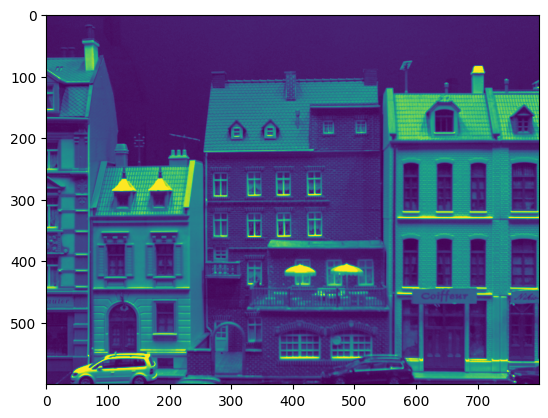

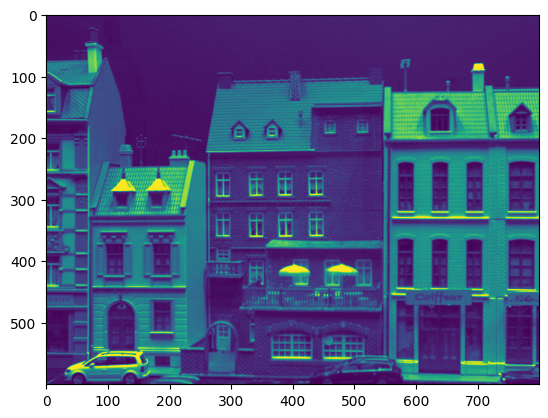

True

In [127]:
#part 9.2

im_data = np.load('TwoImageData.npy', allow_pickle=True).item()
print(im_data.keys())
#compute the fundamental matrix between the two images
data1 = im_data['im1']
print(data1)
print()
data2 = im_data['im2']
print(data2)
#convert to grayscale
im1 = np.uint8(data1)  # Convert to uint8 if necessary
im2 = np.uint8(data2)

plt.imshow(im1)
plt.show()

plt.imshow(im2)
plt.show()
# Save the image to a file using cv2.imwrite()
cv2.imwrite('im1.jpg', im1)
cv2.imwrite('im2.jpg', im2)




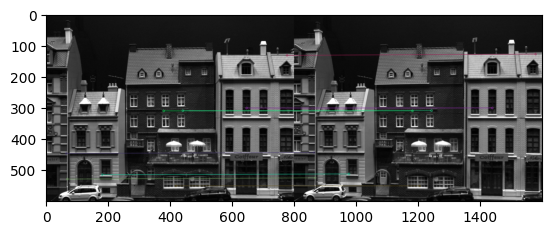

In [131]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher_create(crossCheck= True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance) #ascending

matching_result = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matching_result)
plt.show()


In [143]:
#part 9.3

rnd_matches = np.random.choice(matches, 8, replace=False)

#these arrays are size (N, 2)
rnd_matches1 = np.array([(keypoints1[m.queryIdx].pt[0], keypoints1[m.queryIdx].pt[1]) for m in matches])
rnd_matches2 = np.array([(keypoints2[m.trainIdx].pt[0], keypoints2[m.trainIdx].pt[1]) for m in matches])

# Extract coordinates
matched_points = np.array(
    [
        (
            keypoints1[m.queryIdx].pt[0],
            keypoints1[m.queryIdx].pt[1],
            keypoints2[m.trainIdx].pt[0],
            keypoints2[m.trainIdx].pt[1],
        )
        for m in rnd_matches
    ]
)
print(f"matched_points: {matched_points}")

random_keypoints1 = np.float32([keypoints1[match.queryIdx].pt for match in rnd_matches])
random_keypoints2 = np.float32([keypoints2[match.trainIdx].pt for match in rnd_matches])
print(random_keypoints1.shape)
#make the points 3d with hom coords
random_keypoints1_homogeneous = np.stack((random_keypoints1[:, 0], random_keypoints1[:, 1], np.ones(len(random_keypoints1))), axis=1)
random_keypoints2_homogeneous = np.stack((random_keypoints2[:, 0], random_keypoints2[:, 1], np.ones(len(random_keypoints2))), axis=1)
print(random_keypoints1_homogeneous.shape)

# Estimate fundamental matrix using Fest_8point function
F_estimated = Fest_8point(random_keypoints1.T, random_keypoints2.T)


matched_points: [[572.61303711 180.20948792 734.24603271 163.27702332]
 [260.0333252  308.51516724 263.99398804 308.50769043]
 [568.70941162 382.38082886 560.5892334  291.09292603]
 [527.60430908 450.02658081 518.85394287 450.09451294]
 [378.9239502  308.87149048 381.66098022 308.75396729]
 [335.62228394 167.91586304 341.12084961 168.37483215]
 [335.32989502 331.93899536 284.86529541 266.50991821]
 [521.66784668 538.08911133 509.11767578 539.84442139]]
(8, 2)
(8, 3)


In [145]:
print(f"F from 8-point: {F_estimated}")
print( FTrue)

# is this close enough?

F from 8-point: [[-5.99663754e-06 -7.66187204e-07  9.74378779e-03]
 [ 2.09533005e-05 -7.09928929e-06 -1.08424265e-02]
 [-1.20469212e-02  7.69595684e-03  9.99791550e-01]]
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


In [147]:
def sampsons_distance(F, p1, p2):
    """
    Compute the Sampson distance for the given fundamental matrix and point correspondences.

    Args:
        F (np.ndarray): The fundamental matrix, shape (3, 3).
        p1 (np.ndarray): 2D points in image 1, shape (2, N).
        p2 (np.ndarray): 2D points in image 2, shape (2, N).

    Returns:
        dist (np.ndarray): The Sampson distance for each point, shape (N,).
    """
    # if p1.shape[0] == 3 and p2.shape[0] == 3:
    #     # Normalize points
    #     p1 = p1[:2] / p1[2]
    #     p2 = p2[:2] / p2[2]
    # if p1.shape[0] != 2 or p2.shape[0] != 2:
    #     raise ValueError("p1 and p2 must have shape (2, N).")

    # Make homogeneous to multiply with F
    p1 = pi(p1) #-> from (2,8) to (3,8)
    p2 = pi(p2)

    distances = np.zeros((p1.shape[1], 1))
    # For each pair of points
    for i in range(p1.shape[1]):
        p1i, p2i = p1[:, i], p2[:, i]
        num = (p2i.T @ F @ p1i) ** 2
        denom = (
            (p2i.T @ F[0]) ** 2
            + (p2i.T @ F[1]) ** 2
            + (F @ p1i)[0] ** 2
            + (F @ p1i)[1] ** 2
        )
        dist = num / denom
        distances[i, :] = dist
    return distances

s_dist = sampsons_distance(F_estimated, rnd_matches1.T, rnd_matches2.T)

#inliers
threshold = 3.84 * 3**2
inliers = [idx for idx, dist in enumerate(s_dist) if dist < threshold]
inliers = np.array([rnd_matches1[inliers], rnd_matches2[inliers]])
print(f"inliers.shape: {inliers.shape}")

inliers.shape: (2, 451, 2)


In [148]:
def ransac_fundamental_matrix( matches, keypoints1, keypoints2, threshold: float, iters=1000):
    """
    Estimate the fundamental matrix using RANSAC.

    Args:
        q1 (np.ndarray): 2D points in image 1, shape (2, N).
        q2 (np.ndarray): 2D points in image 2, shape (2, N).
        threshold (float): The threshold used for the RANSAC algorithm.
        iters (int): The number of iterations to run the RANSAC algorithm.

    Returns:
        F (np.ndarray): The estimated fundamental matrix, shape (3, 3).
        inliers (np.ndarray): The inliers used to estimate F, shape (N,).
    """
    im1_matches = np.array(
        [(keypoints1[m.queryIdx].pt[0], keypoints1[m.queryIdx].pt[1]) for m in matches]
    )  # (N, 2)
    im2_matches = np.array(
        [(keypoints2[m.trainIdx].pt[0], keypoints2[m.trainIdx].pt[1]) for m in matches]
    )  # (N, 2)

    best_consensus = 0
    best_inliers = None
    best_F = None

    for i in range(iters):
        # 1. sample 8 random matches
        # 2. use Fest_8point to estimate F matrix from the 8 matches
        # 3. compute sampson's distance
        # 4. find inliers if sampson's distance < threshold
        # 5. update best F and inliers
        # 6. iterate

        # Sample 8 random matches
        match_samples = np.random.choice(matches, 8, replace=False)

        # Extract x-y coordinates of samples
        im1_samples = np.array(
            [
                (keypoints1[m.queryIdx].pt[0], keypoints1[m.queryIdx].pt[1])
                for m in match_samples
            ]
        )  # (8, 2)
        im2_samples = np.array(
            [
                (keypoints2[m.trainIdx].pt[0], keypoints2[m.trainIdx].pt[1])
                for m in match_samples
            ]
        )  # (8, 2)

        F = Fest_8point(im1_samples.T, im2_samples.T)  # requires (2, 8) input

        # Calculate the dist for all matches
        dist_samp = sampsons_distance(F, im1_matches.T, im2_matches.T)
        inliers = [
            idx for idx, dist in enumerate(dist_samp) if dist < threshold
        ]
        inliers = np.array([im1_matches[inliers], im2_matches[inliers]])
        # inliers shape : (2, M, 2)

        consensus = inliers.shape[1]
        # Update best F and inliers
        if consensus > best_consensus:
            best_inliers = inliers
            best_F = F

    if best_F is None:
        raise ValueError("RANSAC did not find any inliers.")

    # Refit the model using all inliers
    print(f"Best consesus of {best_consensus} out of {len(matches)} matches.")
    best_F = Fest_8point(best_inliers[0].T, best_inliers[1].T)

    return best_F, best_inliers


iters = 200
threshold = 3.84 * 3**2  # 34.56
best_F, best_inliers = ransac_fundamental_matrix(matches, keypoints1, keypoints2, threshold, iters)

Best consesus of 0 out of 2086 matches.


In [149]:
print("Ftrue: ", FTrue)
print("best_F: ", best_F)

Ftrue:  [[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
best_F:  [[-2.72875556e-07  4.42457731e-07 -9.85392422e-04]
 [ 1.08306678e-06  5.60109962e-06 -4.71459546e-03]
 [ 5.17156252e-04 -2.78559432e-04  9.99988228e-01]]


In [150]:
# Evaluate the estimated F matrix
(best_F * FTrue).sum() / (np.linalg.norm(best_F) * np.linalg.norm(FTrue))

-0.9779255957419963